In [1]:
import torch
from torch import nn
import sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import numpy as np
from skorch import NeuralNetClassifier
import itertools
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [14]:
# Extract Dataset
# https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification

input_file = "Data/features_30_sec.csv"
with open(input_file) as f:
    f.readline()
    data = np.loadtxt(f, delimiter=',', dtype=np.object_)

labels = [
    'blues', 'classical', 'country', 'disco', 'hiphop', 
    'jazz', 'metal', 'pop', 'reggae', 'rock'
]

X = data[:, 1:-1].astype(np.float32)

min_max_scaler = preprocessing.MinMaxScaler((-1, 1))
X = min_max_scaler.fit_transform(X)

y = [labels.index(l) for l in data[:, -1]]


train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

train_X = torch.tensor(train_X, dtype=torch.float32)
test_X  = torch.tensor(test_X, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.long)
test_y  = torch.tensor(test_y, dtype=torch.long)


In [15]:
torch.manual_seed(123456789)

class Network(nn.Module):
    def __init__(self, in_features: int, out_features: int, dropout: float = 0.5):
        super().__init__()

        self.l1 = nn.Sequential(
            nn.Linear(in_features, l1_features := 256),
            nn.BatchNorm1d(l1_features),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        self.l2 = nn.Sequential(
            nn.Linear(l1_features, l2_features := 32),
            nn.BatchNorm1d(l2_features),
            nn.ReLU(),
        )

        self.l3 = nn.Sequential(
            nn.Linear(l2_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.ReLU(),
        )


    def forward(self, x):
        output = self.l1(x)
        output = self.l2(output)
        output = self.l3(output)
        output = torch.log_softmax(output, dim=1)
        return output

classifier = NeuralNetClassifier(
    # Module
    module=Network,
    module__in_features=58,
    module__out_features=10,
    module__dropout=0.1,
    # Criterion
    criterion=nn.CrossEntropyLoss,
    criterion__reduction='mean',
    # Optimizer
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=0,
    lr=0.01,
    # Training
    max_epochs=75,
    batch_size=128,
    # Misc
    verbose=1,
)

classifier.fit(train_X, train_y)
prediction_probs = classifier.predict(test_X)

print(accuracy_score(test_y, prediction_probs))


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.8257       0.3625        2.1267  0.0312
      2        1.3222       0.4062        1.9566  0.0261
      3        1.1079       0.5312        1.6682  0.1184
      4        0.9588       0.6250        1.4520  0.2317
      5        0.8351       0.6438        1.2821  0.0170
      6        0.7485       0.6625        1.1840  0.0527
      7        0.6522       0.7000        1.0657  0.0449
      8        0.5802       0.7250        1.0001  0.0301
      9        0.5117       0.6937        1.0857  0.0467
     10        0.4618       0.6937        1.0026  0.0305
     11        0.4088       0.7000        1.0109  0.0369
     12        0.3621       0.7438        0.9500  0.0186
     13        0.3370       0.7438        0.9945  0.0292
     14        0.2995       0.6813        1.0054  0.0220
     15        0.2704       0.7438        0.8617  0.0306
     16        0.2438       0.7

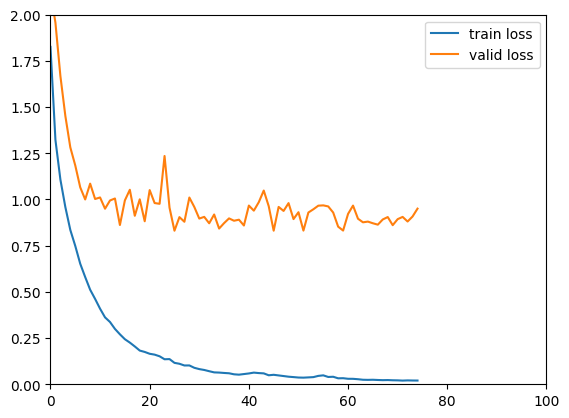

In [16]:
ax = plt.gca()
ax.set_ylim([0, 2])
ax.set_xlim([0, 100])

plt.plot(classifier.history[:, 'train_loss'], label='train loss')
plt.plot(classifier.history[:, 'valid_loss'], label='valid loss')
plt.legend()
plt.show()



In [17]:
from sklearn.model_selection import GridSearchCV

# ((.01, .001, .0001), (.1, .01, .001, .0001, 0)

grid = {
    'lr': [.01, .001, .0001],
    'optimizer__weight_decay': [.01, .001, .0001],
    'module__dropout': [.3, .5, .7]
}
gs = GridSearchCV(classifier, grid, refit=True, cv=5, scoring='accuracy', verbose=4)
gs.fit(train_X, train_y)

print(gs.best_score_, gs.best_params_)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.9859       0.4062        2.1299  0.0150
      2        1.4715       0.4609        2.0276  0.0157
      3        1.3168       0.5547        1.9325  0.0119
      4        1.1576       0.6484        1.8023  0.0109
      5        1.0263       0.6641        1.7156  0.0106
      6        0.9250       0.6328        1.6856  0.0117
      7        0.8533       0.6406        1.6456  0.0124
      8        0.7774       0.5781        1.6203  0.0118
      9        0.7080       0.6016        1.6555  0.0104
     10        0.6512       0.5469        1.6526  0.0170
     11        0.5963       0.5781        1.6330  0.0111
     12        0.5649       0.5312        1.6822  0.0116
     13        0.5421       0.5781        1.5410  0.0154
     14        0.5080       0.5000        1.5892  0.0173
     15        0.5008     